In [ ]:
"""
@author: Bhimraj Yadav
Title: Otitis Media Detection Using Deep Learning using PyTorch
"""

'\n@author: Bhimraj Yadav\nTitle: Otitis Media Detection Using Deep Learning using PyTorch\n'

## Installing Libraries

In [ ]:
!nvidia-smi

Mon Dec 26 07:36:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install pytorch
# !pip3 install numpy --pre torch torchvision torchaudio --force-reinstall --extra-index-url https://download.pytorch.org/whl/nightly/cu117

In [ ]:
import torch
torch.__version__

'1.13.0+cu116'

In [ ]:
# # installing other required dependencies
# !pip install -U albumentations
# !pip install wandb torchmetrics
import wandb
wandb.login()

wandb: Currently logged in as: bhimrazy (kathford). Use `wandb login --relogin` to force relogin


True

## Downloading and Preparing Dataset Folders

In [ ]:
# Downloading Dataset
!wget "https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/21793293/Datos.rar"

# Unzipping RAR File
!unrar x Datos.rar

# Clearing RAR FIle
!rm -rf Datos.rar


In [ ]:
import os 
import glob
import shutil
from tqdm import tqdm

# clearing folder
if (os.path.exists("datasets")):
  shutil.rmtree("datasets/")

# prepairing datasets folders
for cat in ["train","test"]:
  os.makedirs(f"datasets/{cat}/otitis-media", exist_ok = True)
  os.makedirs(f"datasets/{cat}/normal", exist_ok = True)

# train/test folders mapping
folders={
    "train":"Datos/Training-validation",
    "test":"Datos/Testing"
}
# image categories mapping
categories = {
    "otitis-media":"Chronic otitis media",
    "normal":"Normal"
}

# copying files from old(Datos) to new(datasets) folder
for o_k,o_v in tqdm(folders.items()):
  for f_k,f_v in tqdm(categories.items()):
    datas = glob.glob(f"{o_v}/{f_v}/*")
    for data in datas:
      dest = f"datasets/{o_k}/{f_k}/"+data.split("/")[-1]
      # print(data,dest)
      shutil.copyfile(data,dest)

# clearing old data folder 
shutil.rmtree("Datos/")

100%|██████████| 2/2 [00:00<00:00, 49.66it/s]

100%|██████████| 2/2 [00:00<00:00, 26.88it/s]


In [ ]:
import torch
torch.__version__

'2.0.0.dev20221225+cu117'

## Setup


In [ ]:
# wandb setup

# import the library
import wandb

# start a new experiment
run = wandb.init(project="otitis-media-project")



In [ ]:
# creating dataset artifact
artifact = wandb.Artifact('otitis-media', type='dataset')
artifact.add_dir('datasets') # Adds multiple files to artifact
run.log_artifact(artifact) # Creates `otitis-media:v0`

wandb: Adding directory to artifact (./datasets)... Done. 0.1s


In [ ]:
# logging dataset as table
import glob

dataset_table = wandb.Table(columns=["File Name", "Images", "Split","Label"])

files = glob.glob("datasets/*/*/*")
for f in files:
  split = f.split("/")[1]
  label = f.split("/")[2]
  file_name = f.split("/")[3]
  dataset_table.add_data(file_name,
                 wandb.Image(f),
                 split,
                 label
  )
run.log({"Dataset Table": dataset_table})

## Pytorch

In [ ]:
# initialize existing runtime and download data
import wandb

# from existing project
run = wandb.init(project="otitis-media-project",id="260pq1fn")

#download dataset from wandb
artifact = run.use_artifact('kathford/otitis-media-project/otitis-media:v0', type='dataset')
artifact_dir = artifact.download()

wandb:   440 of 440 files downloaded.  


In [ ]:
# importing libraries

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms

import torchmetrics
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn


cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.001, "epochs": 50, "batch_size": 36}

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'artifacts/otitis-media:v0'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=y,
                                             shuffle=True, num_workers=2)
              for x,y in zip(['train', 'test'],[36,40])}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class_names, image_datasets

(['normal', 'otitis-media'], {'train': Dataset ImageFolder
      Number of datapoints: 360
      Root location: artifacts/otitis-media:v0/train
      StandardTransform
  Transform: Compose(
                 Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                 CenterCrop(size=(224, 224))
                 ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                 RandomHorizontalFlip(p=0.5)
                 ToTensor()
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
             ), 'test': Dataset ImageFolder
      Number of datapoints: 80
      Root location: artifacts/otitis-media:v0/test
      StandardTransform
  Transform: Compose(
                 Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                 CenterCrop(size=(224, 224))
                 ToTensor()
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
             )})

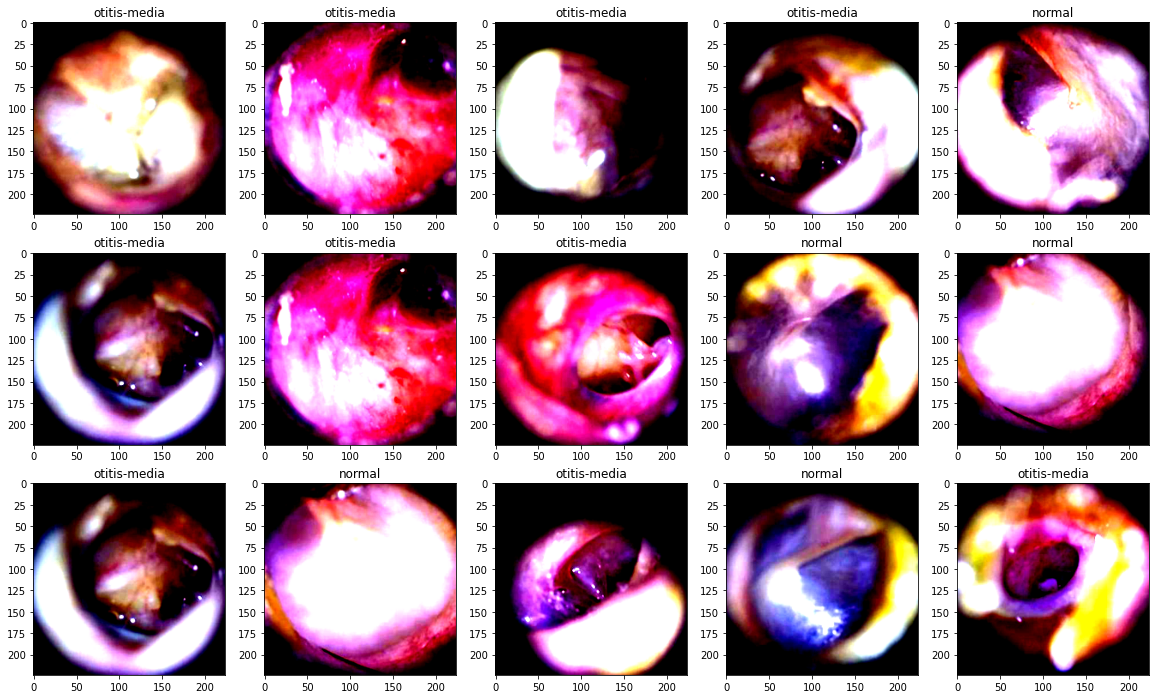

In [ ]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(dataloaders['train']))

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=5,figsize=(20, 12))

# Plot the images in the subplots
for i, ax in enumerate(axs.flat):
    # Get the image and label for the current subplot
    image, label = data[i], labels[i]
    
    # Convert the image to a numpy array and plot it
    img = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    
    # Set the title of the subplot to the label
    ax.set_title(class_names[label])

# Show the plot
plt.show()

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# define model
class DenseNetModel(nn.Module):
    """Resnet50 pretrained model definition."""
    def __init__(self,num_classes):
        super(DenseNetModel,self).__init__()
        self.num_classes = num_classes
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        for param in self.model.parameters():
            param.requires_grad = False
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
                nn.Linear(in_features,in_features//2),
                nn.Dropout(0.5),
                nn.Linear(in_features//2,in_features//4),
                nn.Dropout(0.5),
                nn.Linear(in_features//4,in_features//8),
                nn.Dropout(0.25),
                nn.Linear(in_features//8,self.num_classes),
            )
    def forward(self,x):
        return self.model(x)

model = DenseNetModel(num_classes=2)

# set device
model = model.to(device) 

# Magic
wandb.watch(model, log_freq=5)

[]

In [ ]:
# Define the Binary CrossEntropy with Logits loss function and Adam optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=wandb.config['learning_rate'])

# Decay LR by a factor of 0.1 every 3 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# Define a function for the training loop
def train(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs=5):

    for epoch in range(num_epochs):

        # Training
        # Set the model to training mode
        model.train()

        train_size = 0
        train_loss = 0.0
        train_accuracy = 0.0
        eval_images, eval_labels = None,None

        # Loop through the training dataloader
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # if batch_idx == epoch % wandb.config['batch_size'] : 
            #   eval_images,eval_labels = images, labels

            # else:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            train_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_size += images.size(0)

            if batch_idx  % 5 == 0:
              wandb.log({"train/loss": loss})
              wandb.log({"train/acc": torch.sum(preds == labels.data)/images.size(0)})
              # 🐝 Log train metrics to wandb 
              # wandb.log(metrics)
            

        # # Validation
        # # Evaluate the model on the validation dataset
        # model.eval()
        # with torch.no_grad():
        #     # Forward pass
        #     outputs = model(eval_images)
        #     loss = loss_fn(outputs,F.one_hot(eval_labels,2).float())
        #     val_loss = loss.item()
            
        #     # Compute accuracy
        #     _, preds = torch.max(outputs, 1)
        #     val_accuracy = torch.sum(preds == eval_labels.data)
        #     val_size = eval_images.size(0)

        
        # Testing
        # Evaluate the model on the test dataset
        model.eval()
        with torch.no_grad():
            images, labels = next(iter(test_dataloader))
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs,F.one_hot(labels,2).float())
            test_loss = loss.item()
            
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            test_accuracy = torch.sum(preds == labels.data)
            test_size = images.size(0)

        # Print training and validation statistics
        train_loss = train_loss / train_size
        train_accuracy = train_accuracy / train_size
        # val_accuracy = val_accuracy / val_size
        test_accuracy = test_accuracy / test_size
        
        # 🐝 Log test metrics to wandb
        test_metrics = {"test/test_loss": test_loss, 
                       "test/test_accuracy": test_accuracy}
        wandb.log({**test_metrics})

        # print(f"Train Loss: {train_loss:.3f},Train Accuracy: {train_accuracy:.3f}, Valid Loss: {val_loss:.3f}, Valid Accuracy: {val_accuracy:.2f}, Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}")
        print(f"Train Loss: {train_loss:.3f},Train Accuracy: {train_accuracy:.3f},Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}")

# Train the model
train(model, loss_fn, optimizer, train_dataloader = dataloaders['train'], test_dataloader = dataloaders['test'],num_epochs=50)

Train Loss: 0.507,Train Accuracy: 0.708,Test Loss: 0.925, Test Accuracy: 0.55
Train Loss: 0.159,Train Accuracy: 0.944,Test Loss: 0.581, Test Accuracy: 0.73
Train Loss: 0.094,Train Accuracy: 0.958,Test Loss: 0.177, Test Accuracy: 0.90
Train Loss: 0.084,Train Accuracy: 0.981,Test Loss: 0.176, Test Accuracy: 0.93
Train Loss: 0.058,Train Accuracy: 0.978,Test Loss: 0.005, Test Accuracy: 1.00
Train Loss: 0.021,Train Accuracy: 0.992,Test Loss: 0.003, Test Accuracy: 1.00
Train Loss: 0.009,Train Accuracy: 1.000,Test Loss: 0.001, Test Accuracy: 1.00
Train Loss: 0.006,Train Accuracy: 0.997,Test Loss: 0.001, Test Accuracy: 1.00
Train Loss: 0.003,Train Accuracy: 1.000,Test Loss: 0.000, Test Accuracy: 1.00
Train Loss: 0.056,Train Accuracy: 0.983,Test Loss: 0.050, Test Accuracy: 0.98
Train Loss: 0.015,Train Accuracy: 0.992,Test Loss: 0.000, Test Accuracy: 1.00
Train Loss: 0.028,Train Accuracy: 0.992,Test Loss: 0.000, Test Accuracy: 1.00
Train Loss: 0.004,Train Accuracy: 0.997,Test Loss: 0.004, Test A

In [ ]:
# Testing
# Evaluate the model on the test dataset
model.eval()
with torch.no_grad():
    images, labels = next(iter(dataloaders['test']))
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs,F.one_hot(labels,2).float())
    test_loss = loss.item()
    
    # Compute accuracy
    values, preds = torch.max(torch.sigmoid(outputs), 1)
    test_accuracy = torch.sum(preds == labels.data)

    table = wandb.Table(columns=["image", "target", "prediction", "confidence"])
    for img, targ, pred, prob in zip(images.to("cpu"),labels.to("cpu"), preds.to("cpu"), values.to("cpu")):
        # Convert the image to a numpy array and plot it
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        table.add_data(wandb.Image(img), targ, pred, prob)
    run.log({"predictions_table":table})


In [ ]:
torch.save(model,"otitis-media-model.pt")

# ... Create a Model Version
art = wandb.Artifact(f'otitis-media-model', type="model")

# ... Add the serialized files
art.add_file("otitis-media-model.pt")

run.log_artifact(art)

In [ ]:
# 🐝 Close your wandb run 
run.finish()

loss,▄▁▃▁▁▂▂▂▃▁▃▃▂▁▁▂▁▅▁▁██████████▆▅▁▁▁▁▁▂▁▁
test/test_accuracy,▁▄▆▇████████████████████████████████████
test/test_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁█████████████▆█████▇███████████████████
train/loss,█▂▁▂▁▁▁▁▁▁▁▁▁▂▇▁▁▁▂▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00013
test/test_accuracy,1.0
test/test_loss,1e-05
train/acc,1.0
train/loss,0.00015
